# <img src="Example_data/CosmicWatch_Black.png", width =700>


<h1><center> -- iPython example script for plotting CosmicWatch data --</center></h1>

<h2><center> Useful links:</center></h2>

<h4><center>  [CosmicWatch v3 GitHub Link](https://github.com/spenceraxani/CosmicWatch-Desktop-Muon-Detector-v3)
... Where the most up-to-date version of this script lives.</center></h4>

<h4><center> [Youtube Videos](https://youtu.be/Js-lOOS7sVE)
... Videos showing how to use the detectors. [in progress]</center></h4>


# Requirements to run this script

There are some very standard tools used for making plots and performing calculations using python. This particular script uses Matplotlib, Pylab, and scipy. I beleive they all are contained in Anaconda. So you should simply be able to:
```
pip install anaconda
```
If you don't have admin access to your python installation:
```
pip install --user anaconda
```
Or, maybe you need permission:
```
sudo pip install --user anaconda
```

(`pip` may be `pip3`, `pip3.6`, `pip3.7`, `pip-3.6`, `pip-3.7`, or something like that. It depends on the particulars of your python installation.)

The installation process of libraries depends on your operating system and python version. These libraries are very common, and there is sufficient information available on the internet for you to troubleshoot the installation process.

# Description of what this script does

Want to make a plot of the data you collected from your CosmicWatch detector? This script will show you how to do that. It should be pretty straightforward if you understand what information is being saved to the CosmicWatch data file. The trickiest part is properly accounting for the detector deadtime in order to get an accurate rate measurement.

To use this notebook, you need a CosmicWatch data file. CosmicWatch data files are the .txt files recorded to the microSD card, or the file that was produced when using the import_data.py script. Once you have a file somewhere on your computer, simply input that file into the CWClass below, to make an object that can be used to make different plots. For example:

```
my_data = CWClass('/Users/Spencer/file_location/FileM0001.txt', bin_size = 120)
```

You can now tab complete on the my_data variable (after running the cell, shift-enter) to access the different data data parameters. For example, let's say you want to get an array of the measured barometeric pressure:
```
Event_pressures = my_data.pressure_hpa
```

The bin_size argument in CWClass is for binning the data into total time intervals, in seconds. For example, if you
want to look at the count rate in ten minute intervals, set it to 600. You can then access the binned data with:
```
Binned_data_rate = my_data.binned_count_rate
```

I've also made some python classes to make different plots. Often, you want to plot multiple files, or sets of data, on the same figure. So my python classes take the input data in as a list. You'll see stuff like this:

```
my_data2 = CWClass('/Users/Spencer/file_location/FileM0002.txt', bin_size = 120)
data = [my_data.pressure_hpa, my_data2.pressure_hpa]
colors = ['r', 'b']
```

Here, the figure is going to plot the pressure from two files, with the first file having a color of red, and the second a color of blue. Eaxmples of this are below.


In [1]:
#***********************************************************************************
# Master import
#***********************************************************************************

# Plot data in this window
%matplotlib inline

# Make the ipython cell width the size of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports some libraries
import glob
import sys
import time
import numpy as np
import os

# You might need to install pylab, matplotlib, scipy. They  comes with anaconda, amoung others. >> pip install anaconda
import pylab
from pylab import *
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp


# The current directory
cwd = os.getcwd() 

# The location where we will save figures
save_location = cwd + '/Figures/' 

if not os.path.isdir(save_location):
    os.mkdir(save_location)

# Fontsize and presets for matplotlib

plt.rc('text', usetex=True)
'''
# Allow it to use Latex notation
plt.rc('text', usetex=True)
'''

# Define your own colors for the plots, you can also use 'r' for red or 'g' for green.
mycolors = ['#c70039','#ff5733','#ff8d1a','#ffc300','#eddd53','#add45c','#57c785',
               '#00baad','#2a7b9b','#3d3d6b','#511849','#900c3f','#900c3f'] 

font = { 'size':   24}
matplotlib.rc('font', **font)

print('Imports complete ...')

Imports complete ...


In [2]:
# This class (CWClass) simply takes a CosmicWatch data file as fname, and let's the user select the bin size.
# It converts your file from the CW detector into something more useable.

class CWClass():
    def __init__(self,fname,bin_size = 60):
        self.fname = fname.split('/')[-1]
        self.bin_size = bin_size
        
        data = np.genfromtxt(fname = fname,
                                  delimiter = '\t',dtype = str,invalid_raise=False, comments='#')
        
        for i in range(len(data[:,5])):
            try:
                data[:,5][i] = float(data[:,5][i])
            except:
                data[:,5][i] = 0
        event_number = data[:,0].astype(np.float)
        rtc_time      = data[:,1] # The realtime clock date, if this is off, you need to upload the software.ino code to the detector. It will be updated.
        rtc_date      = data[:,2] # The realtime clock time, if this is off, you need to upload the software.ino code to the detector. It will be updated.
        timestamp = data[:,3].astype(np.float) # a more precise time, in ms.
        adc_H     = data[:,4].astype(np.float) 
        adc_L     = data[:,5].astype(np.float)
        sipm      = data[:,6].astype(np.float) # The calculated SiPM Peak voltage.
        temp      = data[:,7].astype(np.float) # The temperature, measured during each event
        pressure  = data[:,8].astype(np.float) # The pressure, measured during each event
        deadtime   = data[:,9].astype(np.float) # The detector deadtime since the last event.
        coincident= data[:,10].astype(np.float) # Was the event coincident?
        try:
            det_names = set(data[:,11])         # Was the event coincident?
            detector = data[:,11]      
            self.n_detector       = len(set(detName))
        except:
            pass
        
        
        self.timestamp        = np.asarray(timestamp) #-  min(np.asarray(timestamp))       # The absolute time of an event in seconds
        self.timestamp_s      = np.asarray(timestamp)/1000.
        self.SiPM             = sipm
        self.temperature      = temp
        self.pressure_hpa         = pressure/100.
        self.HGain_ADC        = adc_H
        self.LGain_ADC        = adc_L
        self.select_muons       = np.asarray(coincident == 1)
        self.select_non_muons       = np.invert(self.select_muons)
        self.detector = detector
        
        self.total_counts     = len(event_number)
        self.total_muons     = len(event_number[self.select_muons])
        self.event_deadtime_us  = deadtime
        self.event_deadtime_ms  = deadtime/1000.            # an array of the measured event deadtime in miliseconds
        self.event_deadtime_s   = self.event_deadtime_ms/1000.
        self.total_deadtime_s   = sum(self.event_deadtime_s)            # an array of the measured event deadtime in miliseconds
        self.livetime = max(self.timestamp_s)- self.total_deadtime_s

        mjd_time_stamp = []
        for i in range(len(rtc_date)):
            year  = int(rtc_date[i].split('/')[0])
            month = int(rtc_date[i].split('/')[1])
            day   = int(rtc_date[i].split('/')[2])
            hour  = int(rtc_time[i].split(':')[0])
            mins  = int(rtc_time[i].split(':')[1])
            sec   = int(np.floor(float(rtc_time[i].split(':')[2])))
            try:  
                decimal = float('0.'+str(rtc_time[i].split('.')[-1]))
            except:
                decimal = 0.0
            mjd_time_stamp.append(float(time.mktime((year, month, day, hour, mins, sec, 0, 0, 0)))+ decimal) 

        self.mjd_time_stamp     = np.asarray(mjd_time_stamp) -  min(np.asarray(mjd_time_stamp))       # modified julian date
        
        
        bins = range(0,int(max(self.timestamp_s)), self.bin_size)
        bin_deadtime, binEdges = np.histogram(self.timestamp_s, bins = bins,weights = self.event_deadtime_s)
        
        # binned data
        counts, binEdges       = np.histogram(self.timestamp_s, bins = bins)
        
        self.count_rate       = self.total_counts/self.livetime 
        self.count_rate_err   = np.sqrt(self.total_counts)/self.livetime 
        self.event_livetime_s = diff(np.append([0],self.timestamp_s)) - self.event_deadtime_s
        self.binned_counts     = counts
        self.binned_counts_err = np.sqrt(counts)
        self.binned_count_rate = counts/(bin_size-bin_deadtime)
        self.binned_count_rate_err = np.sqrt(counts)/(bin_size-bin_deadtime)
        print("--> "+self.fname)
        print('\tTotal Count rate: '+str(np.round(self.count_rate,4)) +' +/- '+ str(np.round(self.count_rate_err,4))+'Hz')
        
        
        # Coincident binned data
        counts_muons, binEdges        = np.histogram(self.timestamp_s[self.select_muons], bins = bins)
        self.count_rate_muons       = self.total_muons/self.livetime
        self.count_rate_err_muons   = np.sqrt(self.total_muons)/self.livetime         
        self.binned_counts_muons     = counts_muons
        self.binned_counts_err_muons = np.sqrt(counts_muons)
        self.binned_count_rate_muons = counts_muons/(bin_size-bin_deadtime)
        self.binned_count_rate_err_muons = np.sqrt(counts_muons)/(bin_size-bin_deadtime)
        print('\tCoincident Count rate: '+str(np.round(self.count_rate_muons,4)) +' +/- '+ str(np.round(self.count_rate_err_muons,4))+'Hz')
        
        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        self.bin_size          = bin_size
        self.binned_time_s     = bincenters
        self.binned_time_m     = bincenters/60.
        


In [3]:
# Let's input a test file. Bin size is in seconds, 600s = 10mins.
f1 = CWClass(cwd + "/Example_data/Example_coincidence_file.TXT", bin_size = 120)

print("Average temperature during measurent: "+str(np.round(np.average(f1.temperature),2))+'C')
print("Average pressure during measurent: "+str(np.round(np.average(f1.pressure_hpa),2))+'hPa')
print("Max SiPM pulse during measurent: "+str(np.round(max(f1.SiPM),2))+'mV')

--> Example_coincidence_file.TXT
	Total Count rate: 3.1014 +/- 0.0095Hz
	Coincident Count rate: 0.3711 +/- 0.0033Hz
Average temperature during measurent: 29.52C
Average pressure during measurent: 1019.12hPa
Max SiPM pulse during measurent: 208.59mV


Notice that when you uploaded your file, once completed, it printed out the total measured count rate for all observed events, and strictly for coincident events.

# Example rate measurement

In [6]:
# This function will plot the rate as a function of time, given the bin_size you selected above.
# Time, count_rates, count_rates_err, color, lables -- these are lists of the data that you want to supper impose onto the figure.
font = { 'size':   24}
matplotlib.rc('font', **font)

def NPlot(time, # The binning times
             count_rates, # The measured count rate in each bin
             count_rates_err, # The statistical uncertainty in the count rate
             colors, # The color you want to use for the plot
             labels, # The label of the data
             xmin,xmax,ymin,ymax,autoscale =False, # setting up the axis
             figsize = [10,10],fontsize = 18, alpha = 0.9, # The figure aspect ratio, font size, alpha is the opacity.
             xscale = 'linear',yscale = 'linear', # Do you want a "linear" or "log" plot.
             xlabel = '',ylabel = '', # What do you want the axis labels to be?
             loc = 1,pdf_name='',title = ''): # loc is 1,2,3 or 4, and will change the location of the legend. pdf_name is the output fig name.
         
        f = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = f.add_subplot(111)

        for i in range(len(count_rates)):
            pylab.errorbar(time[i], 
                           count_rates[i],
                           xerr=0, yerr=count_rates_err[i],
                           fmt= 'ko',label = labels[i], linewidth = 2, ecolor = colors[i], markersize = 2)

        pylab.yscale(yscale, nonposy='clip')
        pylab.xscale(xscale, nonposx='clip')
        pylab.ylabel(ylabel)
        pylab.xlabel(xlabel)
        if autoscale:
            xmin = min(time[0])
            xmax = max(time[0])
            ymin = 0
            ymax = (max(count_rates[0])+max(count_rates_err[0]))*1.3
            for i in range(len(count_rates)):
                if min(time[i]) < xmin:
                    xmin = min(time[i])
                if max(time[i]) > xmax:                
                    xmax = max(time[i])
                if (max(count_rates[i])+max(count_rates_err[i]))*1.3 > ymax:
                    ymax = (max(count_rates[i])+max(count_rates_err[i]))*1.3
            pylab.axis([xmin, xmax, ymin,ymax])
        else:
            pylab.axis([xmin, xmax, ymin,ymax])
        
        pylab.legend(loc=loc, shadow=True,fontsize = 24,frameon = 0,fancybox = True)
        pylab.tight_layout()
        plt.title(title)
        if pdf_name != '':
            plt.savefig(save_location+ '/' + pdf_name, format='pdf',transparent =True)
            print("Saving: "+save_location+ '/' + pdf_name)
        pylab.show()
        

Saving: /Users/HAL9000/Dropbox (MIT)/CosmicWatch/GitHub/CosmicWatch-Desktop-Muon-Detector-v3/Plotting/Figures//Rate_measurement.pdf


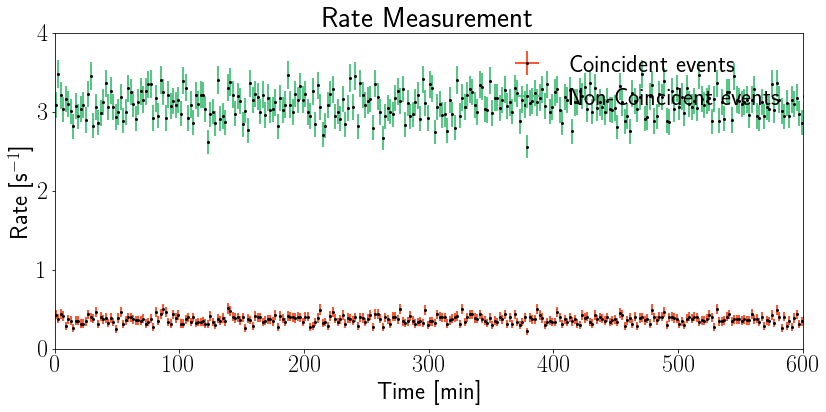

In [7]:
# Note, the number of entries in the time list, must equal the number of entries in count_rates, count_rates_err, colors, and labels.
NPlot(time = [f1.binned_time_m,f1.binned_time_m], 
         count_rates = [f1.binned_count_rate_muons,f1.binned_count_rate],
         count_rates_err = [f1.binned_count_rate_err_muons,f1.binned_count_rate_err],
         colors =[mycolors[1],mycolors[6]],
         labels = [r'Coincident events',r'Non-Coincident events'],
         autoscale=False,
         xmin = 0,xmax = 600,ymin = 0,ymax = 4,
         figsize = [12,6],fontsize = 20,alpha = 1,
         xscale = 'linear',yscale = 'linear',
         xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
         loc = 1,pdf_name='Rate_measurement.pdf',title = 'Rate Measurement')

# Play around with the settings.
# If the labelling looks small, rerun the master import a few cells above. 

#  Example pressure and temperature plot

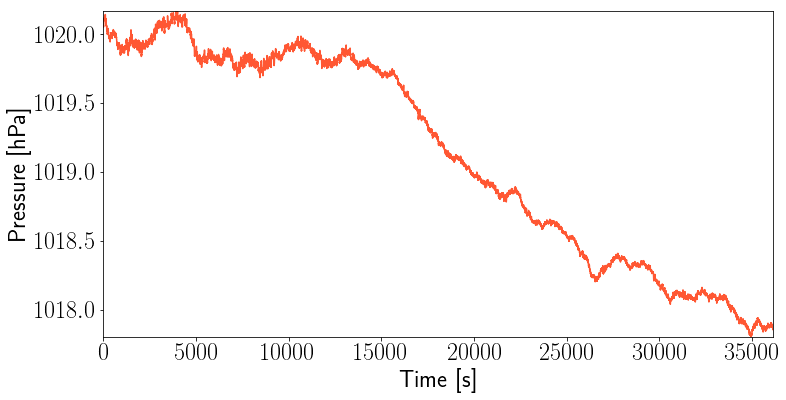

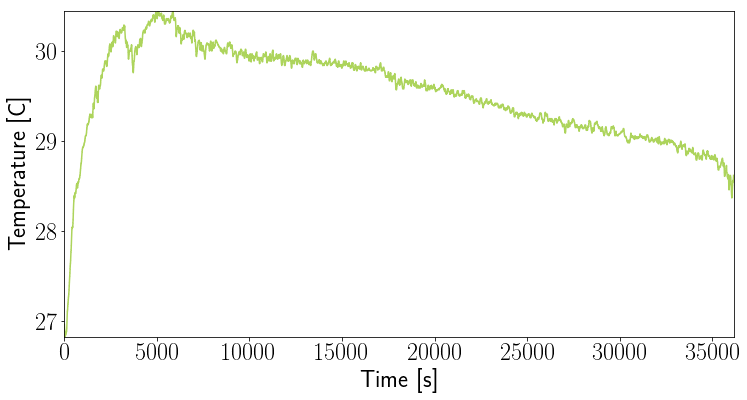

In [8]:
# Here is the a very short example of matplotlib, pylab, without using my classes above.
figsize = [12,6]
f = plt.figure(figsize=(figsize[0], figsize[1])) 
ax1 = f.add_subplot(111)
pylab.ylabel('Pressure [hPa]')
pylab.xlabel("Time [s]")
pylab.axis([min(f1.timestamp_s), max(f1.timestamp_s), min(f1.pressure_hpa),max(f1.pressure_hpa)])
plt.plot(f1.timestamp_s,f1.pressure_hpa,color = mycolors[1])
plt.savefig(save_location+ '/Pressure.pdf', format='pdf',transparent =True)
pylab.show()

f = plt.figure(figsize=(figsize[0], figsize[1])) 
ax1 = f.add_subplot(111)
pylab.ylabel('Temperature [C]')
#plt.text(2500, 27, r'The temperature seems precise, but maybe not super accurate')
pylab.xlabel("Time [s]")
pylab.axis([min(f1.timestamp_s), max(f1.timestamp_s), min(f1.temperature),max(f1.temperature)])
plt.plot(f1.timestamp_s,f1.temperature,color = mycolors[5])
plt.savefig(save_location+ '/Temperature.pdf', format='pdf',transparent =True)
pylab.show()


# Example Multiple histogram 

In [9]:
# Maybe you want to histogram the data, rather than look at rate as a function of time. 
# The following does this and includes the statistical errors in the bins.

def plusSTD(n,array):
    xh = np.add(n,np.sqrt(np.abs(array)))
    return xh

def subSTD(n,array):
    xl = np.subtract(n,np.sqrt(np.abs(array)))
    return xl

def fill_between_steps(x, y1, y2=0, h_align='mid', ax=None,lw=2, **kwargs):
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:]
    # Now: the average x binwidth
    xstep = sp.repeat((x[1:] - x[:-1]), 2)
    xstep = sp.concatenate(([xstep[0]], xstep, [xstep[-1]]))
    # Now: add one step at end of row.
    xx = sp.append(xx, xx.max() + xstep[-1])

    # Make it possible to chenge step alignment.
    if h_align == 'mid':
        xx -= xstep / 2.
    elif h_align == 'right':
        xx -= xstep

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == sp.ndarray:
        y2 = y2.repeat(2)#[:-1]

    # now to the plotting part:
    ax.fill_between(xx, y1, y2=y2,lw=lw, **kwargs)
    return ax


def NHist(data,
         colors,
         labels,
         xmin,xmax,ymin,ymax,
         normalize=False,figsize = [10,10],fontsize = 18,nbins = 101, alpha = 0.9,
         xscale = 'log',yscale = 'log',
         xlabel = '',ylabel='',
         loc = 1,pdf_name='',lw=2, title=''):
        
    fig = plt.figure(figsize=(figsize[0], figsize[1])) 
    ax1 = fig.add_subplot(111)

    if xscale == 'log':
        bins = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
    if xscale == 'linear':
        bins = np.linspace(xmin,xmax,nbins)

    for i in range(len(data)):
        counts,binEdges = np.histogram(data[i][~np.isnan(data[i])],bins = bins,weights = np.ones(len(data[i])),range= (200,1024))

        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        sumWeightsSqrd, binEdges = np.histogram(data[i][~np.isnan(data[i])], bins = bins, weights = np.power(np.ones(len(data[i])),2),range= (200,1024))

        if normalize:
            fill_between_steps(bincenters, plusSTD(counts,sumWeightsSqrd)/sum(counts),subSTD(counts,sumWeightsSqrd)/sum(counts),  color = colors[i],alpha = alpha,lw=lw)
        else:
            fill_between_steps(bincenters, plusSTD(counts,sumWeightsSqrd),subSTD(counts,sumWeightsSqrd),  color = colors[i],alpha = alpha,lw=lw)
        pylab.plot([1e14,1e14], label = labels[i],color = colors[i],alpha = alpha,linewidth = 2)

    pylab.yscale(yscale, nonposy='clip')
    pylab.xscale(xscale, nonposx='clip')
    pylab.grid(b=True, which='major', color='k', alpha = 0.1,linestyle='-')
    pylab.grid(b=True, which='minor', color='k',alpha = .05,  linestyle='-')
    pylab.legend(fontsize=fontsize-2,loc = loc,  fancybox = True,frameon=True)
    pylab.ylabel(ylabel,size=fontsize)
    pylab.xlabel(xlabel, labelpad=20,size=fontsize)
    pylab.axis([xmin, xmax, ymin,ymax])
    plt.title(title,fontsize=fontsize)
    pylab.tight_layout()
    if pdf_name != '':
        plt.savefig(save_location+ '/' + pdf_name, format='pdf',transparent =True)
        print("Saving: "+save_location+ '/' + pdf_name)
    pylab.show()
    #example of accesing the data from the class



Saving: /Users/HAL9000/Dropbox (MIT)/CosmicWatch/GitHub/CosmicWatch-Desktop-Muon-Detector-v3/Plotting/Figures//Multiple_histgrams.pdf


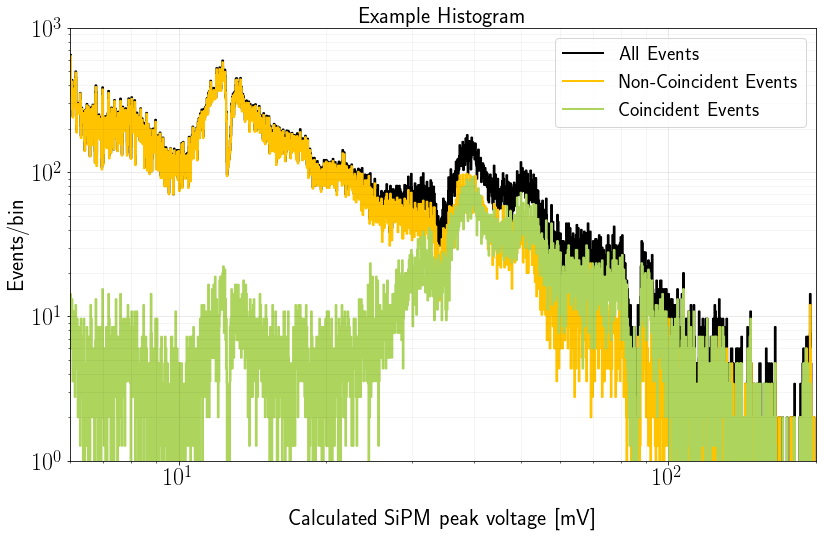

In [11]:
# f1.SiPM is an array of SiPM values from file 1.
# [f1.select_non_muons] is an array of Trues and Falses. 
#    This is called a mask. When you multiply a numpy array by a mask, 
#    it removes all the elements that correspond to False. In this case, 
#    f1.SiPM is all the events
#    f1.SiPM[f1.select_non_muons] is an array of the events that are not tagged as coincident events
#    f1.SiPM[f1.select_muons] is an array of the events that are tagged as coincident events

NHist(data = [f1.SiPM, f1.SiPM[f1.select_non_muons],f1.SiPM[f1.select_muons]], 
    colors = ['k', mycolors[3], mycolors[5]], # you can also use standard colors like 'red', 'black' etc
    labels = ['All Events','Non-Coincident Events','Coincident Events'],
    figsize = [12,8],
    normalize = False,
    fontsize = 22,
    xmin = 6, xmax = 200,ymin = 1,ymax =1000,
    nbins =  1001, alpha = 1, lw=2,
    xscale = 'log',yscale = 'log',# you can type linear or log
    xlabel = 'Calculated SiPM peak voltage [mV]',
    ylabel = "Events/bin",
    title = 'Example Histogram',
    loc = 1, pdf_name='Multiple_histgrams.pdf')

# This plot is telling you that SiPM peak voltages above ~40mV are dominated by muons rather than backgrounds.
# That is, you can see that the green histgoram is ~ larger than the yellow, above ~40mV.
# In the low SiPM peak voltages, you can see those are primarily non-coincident events, which are primarily background gamma radiation.